# Generating terrible priors

Author: Melissa

To support work on PhotoD incubator, I was not able to reach the priors files I wanted. So I figured I would make my own. It went weirdly, so I'm showing my work.

This creates a simple "map" table dataset that is a map of `{order 3 pixel -> sum of objects in all child pixels}`. This is an appropriate proxy for a kernel density estimate.

In [1]:
import lsdb
import healpy as hp

In [2]:
target_pixels = [40, 42, 43, 46, 47, 58, 59, 62, 63]

In [3]:
from lsdb.core.search.pixel_search import PixelSearch

pixel_search = PixelSearch(pixels=[(3, pix) for pix in target_pixels])

In [4]:
gaia = lsdb.read_hats("/data3/epyc/data3/hats/catalogs/gaia_dr3/gaia", search_filter=pixel_search)

In [5]:
gaia_pixel_list = gaia.get_healpix_pixels()

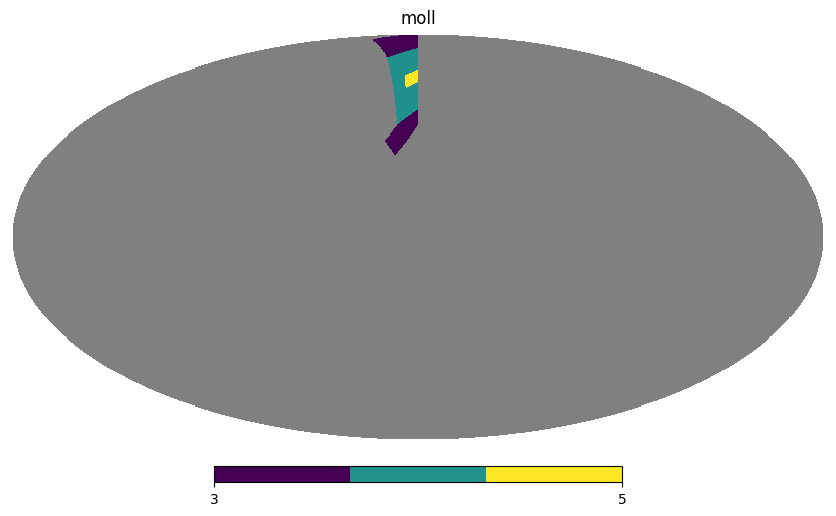

In [6]:
gaia.plot_pixels()

From the 9 order 3 pixels above, we have 25 pixels of mixed order, between 3 and 5.

In [7]:
gaia_pixel_list

[Order: 3, Pixel: 40,
 Order: 3, Pixel: 42,
 Order: 4, Pixel: 172,
 Order: 4, Pixel: 173,
 Order: 4, Pixel: 174,
 Order: 4, Pixel: 175,
 Order: 4, Pixel: 184,
 Order: 4, Pixel: 185,
 Order: 4, Pixel: 186,
 Order: 4, Pixel: 187,
 Order: 4, Pixel: 188,
 Order: 4, Pixel: 189,
 Order: 5, Pixel: 760,
 Order: 5, Pixel: 761,
 Order: 5, Pixel: 762,
 Order: 5, Pixel: 763,
 Order: 5, Pixel: 764,
 Order: 5, Pixel: 765,
 Order: 5, Pixel: 766,
 Order: 5, Pixel: 767,
 Order: 4, Pixel: 232,
 Order: 4, Pixel: 233,
 Order: 4, Pixel: 234,
 Order: 4, Pixel: 235,
 Order: 4, Pixel: 236,
 Order: 4, Pixel: 237,
 Order: 4, Pixel: 238,
 Order: 4, Pixel: 239,
 Order: 3, Pixel: 62,
 Order: 3, Pixel: 63]

In [8]:
hist = gaia.skymap_histogram(lambda x, p: len(x))

In [9]:
big_sum = 0
vals = []
for pix in target_pixels:
    ## This is a HACK and it's bad.
    little_sum = int(sum(set(hist[pix*16: (pix+1)*16])))
    vals.append(little_sum)
    big_sum += little_sum
    
print(big_sum)

15722625


In [10]:
## Confirm that the totals are the same.
len(gaia.compute())

15722625

In [11]:
from hats.pixel_math.spatial_index import healpix_to_spatial_index

healpix_29 = healpix_to_spatial_index(3, target_pixels)

Create a simple dataframe with `healpix_29` of the order 3 pixel and the count of objects. This will include galaxies and other non-star things, but I'm being lazy and calling it `"star_count"`.

In [12]:
import pandas as pd

value_frame = pd.DataFrame({"_healpix_29": healpix_29, "star_count": vals})
value_frame

,_healpix_29,star_count
0,180143985094819840,462369
1,189151184349560832,785367
2,193654783976931328,1355242
3,207165582859042816,2482194
4,211669182486413312,3957394
5,261208778387488768,3014816
6,265712378014859264,2112621
7,279223176896970752,977035
8,283726776524341248,575587


In [13]:
value_frame.to_csv("value_frame.csv", index=False)

In [14]:
## Import it into a "catalog". This is a HACK as well, and could be done better, later.

from dask.distributed import Client
from hats_import.catalog.arguments import ImportArguments
from hats_import.pipeline import pipeline_with_client

args = ImportArguments(
    constant_healpix_order=3,
    use_healpix_29=True,
    file_reader="csv",
    input_file_list=["value_frame.csv"],
    output_artifact_name="star_counts",
    output_path="/astro/users/mmd11/data",
    resume=False,
)

with Client(n_workers=1) as client:
    pipeline_with_client(args, client)

/astro/users/mmd11/.conda/envs/hatsenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39133 instead
  warnings.warn(


Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/1 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/1 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/9 [00:00<?, ?it/s]

Finishing :   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
star_count_map = lsdb.read_hats("/astro/users/mmd11/data/star_counts")
len(star_count_map)

9

PERFECT!!! Moving on to **using** the data in some interesting way!